In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os.path
import math
import hypernetx as hnx

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from chains import dfToDict, dictToDF
from incidenceToProjection import makeHiC_fromInc
from utils import flatten

## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'


 No module named 'celluloid'. If you need to use hypernetx.algorithms.contagion, please install additional packages by running the following command: pip install .['all']


In [3]:
## Double checking that there weren't any distances below 500 in here (based on multiway stuff)

f = f'{dataDir}chains_500_10000_1500_1681171613/chain_dist_10011.txt'
dm = np.loadtxt(f)

dm.shape

(500, 500)

In [6]:
pd.DataFrame(dm).iloc[[1,3,5,7],[1,3,5,7]]

,1,3,5,7
1,0.000000,404.266651,870.294202,1183.326478
3,404.266651,0.000000,489.856784,813.780166
5,870.294202,489.856784,0.000000,575.035876
7,1183.326478,813.780166,575.035876,0.000000


In [9]:
## Read in example file
projMat = None
numFiles = 1000
counter = 0
for i in range(1,numFiles):
    filePath = f'{dataDir}chains_7k_500_projectionMtxOutput_sample2/projMat_3_600_750_{i}.txt'
    if os.path.isfile(filePath):
        counter += 1
        if projMat is None:
            projMat = np.loadtxt(filePath)
        else:
            projMat += np.loadtxt(filePath)
if projMat is not None:
    projMat = projMat.astype('float64')
    projMat /= counter

nrow = projMat.shape[0]

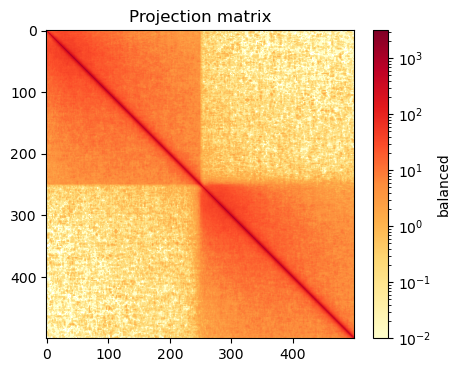

In [13]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(6, 4))
im = plt.imshow(projMat, cmap="YlOrRd",norm = LogNorm(vmax=10**3.5, vmin = 0.01)) #
plt.colorbar(im, fraction=0.046, pad=0.04, label='balanced');
plt.title("Projection matrix")
plt.show()

In [30]:
## read in summary file
summaryFile = f'{dataDir}chains_10k_500_projectionMtxOutput/summary.txt'
summary = pd.read_table(summaryFile,names=["runID","numReads","maxCard","dist_prim","dist_sec","offDiag"])
summary.head()

,runID,numReads,maxCard,dist_prim,dist_sec,offDiag
0,172,108743,10.0,600,750,3
1,115,120276,11.0,600,750,3
2,170,104062,10.0,600,750,3
3,174,113102,10.0,600,750,3
4,155,102053,10.0,600,750,3


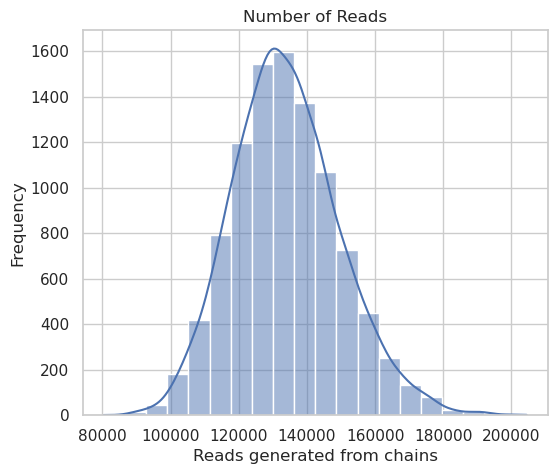

In [31]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Plot a histogram using seaborn
plt.figure(figsize=(6, 5))  # Set the figure size
sns.histplot(data=summary, x="numReads", bins=20, kde=True)  

# Set x and y limits
# plt.xlim(0, 11*10**4) 
# plt.ylim(0, 2000) 

# Add labels and title
plt.xlabel("Reads generated from chains")
plt.ylabel("Frequency")
plt.title("Number of Reads")

# Show the plot
plt.show()

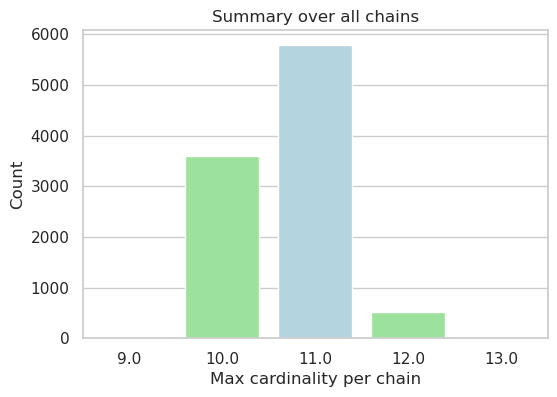

In [32]:
# Plot a bar plot using seaborn
plt.figure(figsize=(6, 4))  # Set the figure size

# Define custom colors
custom_colors = ["lightblue","lightgreen"]
sns.countplot(data=summary, x="maxCard",palette = custom_colors)

# Add labels and title
plt.xlabel("Max cardinality per chain")
plt.ylabel("Count")
plt.title("Summary over all chains")

# Show the plot
plt.show()

In [18]:
ix = 3
filePath = f'{dataDir}chains_7k_500_projectionMtxOutput_sample2/incDF_3_600_750_{ix}.pkl'
incDF = pd.read_pickle(filePath)
filePath = f'{dataDir}chains_7k_500_projectionMtxOutput_sample2/binConcatInc_3_600_750_{ix}.pkl'
bIncDF = pd.read_pickle(filePath)

print(incDF.shape)
print(bIncDF.shape)

(500, 124902)
(100, 121024)


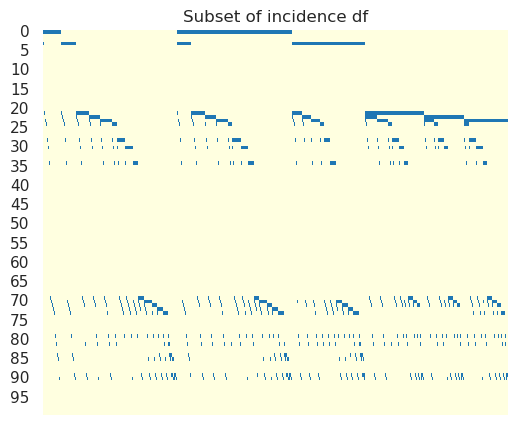

In [19]:
# Define custom colors for the heatmap
colors = ["#FFFFE0", "#1F77B4"]

subset_df = incDF.iloc[:100,:500]

plt.figure(figsize=(6, 5))  # Set the figure size
sns.heatmap(data=subset_df, cmap=colors, cbar=False,xticklabels=False)  # Use the custom colors and remove color bar

# Add title
plt.title("Subset of incidence df")

# Show the plot
plt.show()

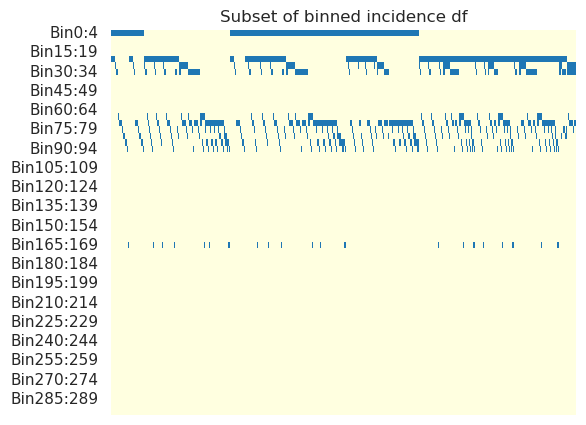

In [20]:
# Define custom colors for the heatmap
colors = ["#FFFFE0", "#1F77B4"]

subset_df = bIncDF.iloc[:60,:500]

plt.figure(figsize=(6, 5))  # Set the figure size
sns.heatmap(data=subset_df, cmap=colors, cbar=False,xticklabels=False)  # Use the custom colors and remove color bar

# Add title
plt.title("Subset of binned incidence df")

# Show the plot
plt.show()

In [97]:
def constructFullDict(listOfDFs):
    """Takes in a list of DFs and outputs a dict"""
    result_dict = {}
    numEdges = []
    for df in listOfDFs:
        result_dict = dfToDict(df,result_dict)
        nE = len(result_dict)
        numEdges.append(nE)
    return(result_dict,numEdges)

In [98]:
## Was playing around with 50. Ran a job for 1000
numFiles = 50

fileList = []
for ix in range(1,numFiles+1):
    filePath = f'{dataDir}chains_10k_500_projectionMtxOutput/binConcatInc_{ix}.pkl'
    if os.path.isfile(filePath):
        bIncDF = pd.read_pickle(filePath)
        fileList.append(bIncDF)

hpEdges, numEdges = constructFullDict(fileList)

In [2]:
import pickle
numFiles = 10000
with open(f'{dataDir}makeHyperGraphDict/hyperEdges_3_600_750_{numFiles}_chains.pkl','rb') as f:
    hpEdges = pickle.load(f)

numEdges = np.loadtxt(f'{dataDir}makeHyperGraphDict/numEdges_3_600_750_{numFiles}_chains.txt')

In [33]:
## Trying to see if the off diagonal distance is contributing to the pruning issues
## Apparently not mitigated
import pickle
numFiles = 10000
with open(f'{dataDir}makeHyperGraphDict/10k_sample1/hyperEdges_3_600_750_final_chains.pkl','rb') as f:
    hpEdges = pickle.load(f)

numEdges = np.loadtxt(f'{dataDir}makeHyperGraphDict/10k_sample1/numEdges_3_600_750_final_chains.txt')

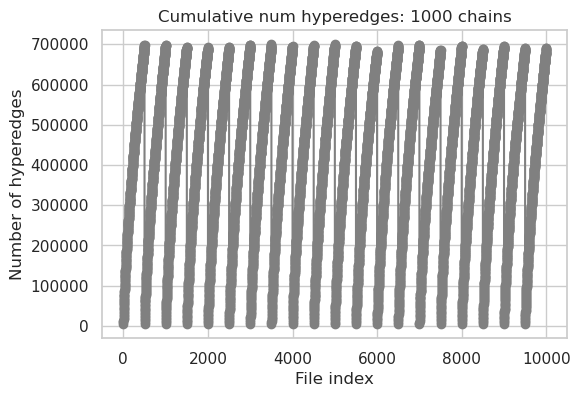

In [6]:
plt.figure(figsize=(6, 4))

indices = list(range(1,len(numEdges)+1))

# Create a dot plot with connecting lines
plt.plot(indices, numEdges, marker='o', linestyle='-', color='grey')

# Add labels and title
plt.xlabel("File index")
plt.ylabel("Number of hyperedges")
plt.title(f"Cumulative num hyperedges: {numFiles} chains")

# Show the plot
plt.show()

## Does not work anymore after the chunking UGH

In [34]:
card = [len(k.split("_")) for k in hpEdges.keys()]
edgeSupport = [v for v in hpEdges.values()]

edgeSupp_byCard = pd.DataFrame({'Cardinality':card, 'ReadSupportPerHPE': edgeSupport})
edgeSupp_byCard.head()

,Cardinality,ReadSupportPerHPE
0,2,5858
1,2,5895
2,2,5519
3,2,2086
4,2,1904


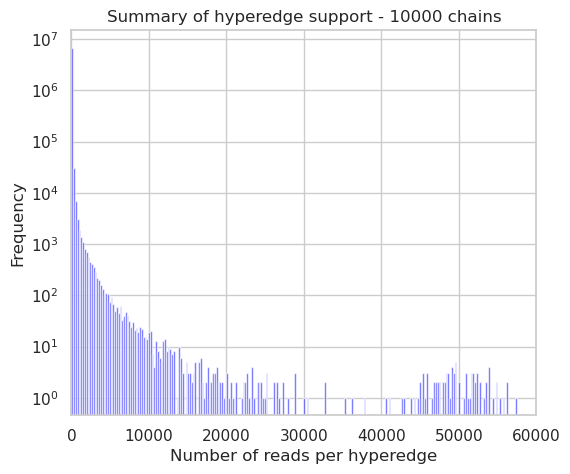

In [35]:
numFiles = 10000
# Set the style for seaborn
sns.set(style="whitegrid")

# Plot a histogram using seaborn
plt.figure(figsize=(6, 5))  # Set the figure size
plt.hist(edgeSupport, bins = 250, color='blue', alpha=0.7)

# Set x and y limits
plt.yscale("log")
plt.xlim(0, 60000) 

# Add labels and title
plt.xlabel("Number of reads per hyperedge")
plt.ylabel("Frequency")
plt.title(f"Summary of hyperedge support - {numFiles} chains")

# Show the plot
plt.show()

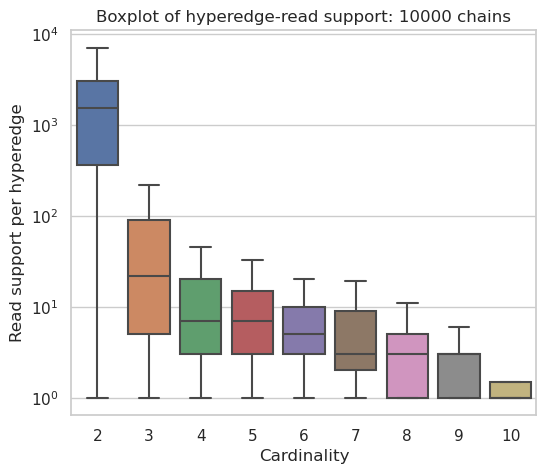

In [36]:
# Create a boxplot using seaborn
plt.figure(figsize=(6, 5))
sns.boxplot(data=edgeSupp_byCard, x='Cardinality', y='ReadSupportPerHPE',showfliers=False)

#plt.xlim(0, 50)
plt.yscale("log")

# Add labels and title
plt.xlabel("Cardinality")
plt.ylabel("Read support per hyperedge")
plt.title(f"Boxplot of hyperedge-read support: {numFiles} chains")

# Show the plot
plt.show()

## Evaluate best distance cutoff 

In [2]:
sf = f'{dataDir}eval_optimalDistCutoff/summary.txt'
summaryFile = pd.DataFrame(np.loadtxt(sf),columns=['ID','numReads','maxCard','dist_prim','dist_sec','offDiagDist'])
summaryFile.head()

,ID,numReads,maxCard,dist_prim,dist_sec,offDiagDist
0,1.0,2864.0,4.0,500.0,500.0,2.0
1,2.0,4075.0,6.0,500.0,550.0,2.0
2,4.0,7934.0,7.0,500.0,650.0,2.0
3,3.0,6004.0,6.0,500.0,600.0,2.0
4,5.0,15099.0,9.0,500.0,750.0,2.0


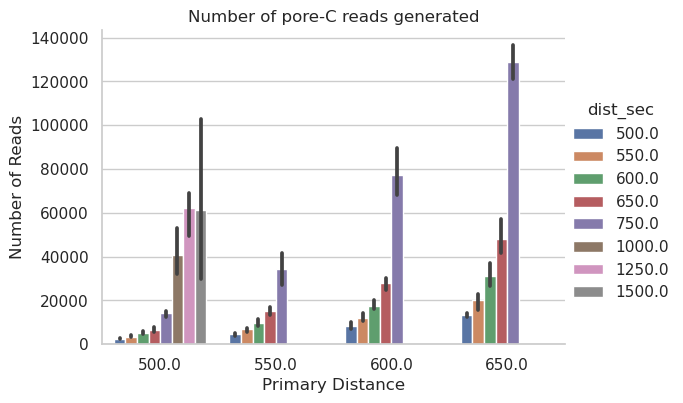

In [11]:
# Create faceted bar plots using seaborn
sns.set(style="whitegrid")  # Set the plot style

# Create the bar plot
g = sns.catplot(
    data=summaryFile,
    x="dist_prim",
    hue="dist_sec",
    y="numReads",
    kind="bar",
    height=4,
    aspect=1.5,
)

# Customize the plot
g.set_axis_labels("Primary Distance", "Number of Reads")
g.set(title="Number of pore-C reads generated")

# Show the plot
plt.show()


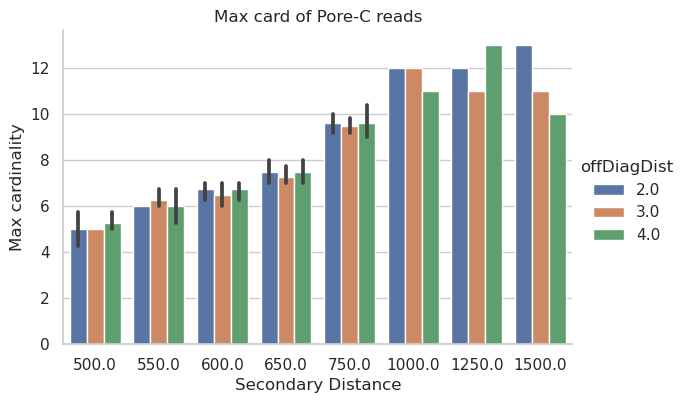

In [14]:
# Create faceted bar plots using seaborn
sns.set(style="whitegrid")  # Set the plot style

# Create the bar plot
g = sns.catplot(
    data=summaryFile,
    x="dist_sec",
    hue="offDiagDist",
    y="maxCard",
    kind="bar",
    height=4,
    aspect=1.5,
)

# Customize the plot
g.set_axis_labels("Secondary Distance", "Max cardinality")
g.set(title="Max card of Pore-C reads")

# Show the plot
plt.show()

In [3]:
allFiles = os.listdir(f'{dataDir}eval_optimalDistCutoff/')
fileList = {}
cardDict = {}
projMats = {}
for file in allFiles:
    if 'incDF_3_' in file and '750' in file:
        bIncDF = pd.read_pickle(f'{dataDir}eval_optimalDistCutoff/{file}')
        fileList[file] = bIncDF
        card = bIncDF.sum()
        cardDict[file] = card
        hic_mat = makeHiC_fromInc(bIncDF)
        projMats[file] = hic_mat


In [12]:
del cardDict['incDF_3_600_750_111.pkl']
del cardDict['incDF_3_550_750_107.pkl']
cardDict.keys()

del projMats['incDF_3_600_750_111.pkl']
del projMats['incDF_3_550_750_107.pkl']

In [9]:
card.max()

9.0

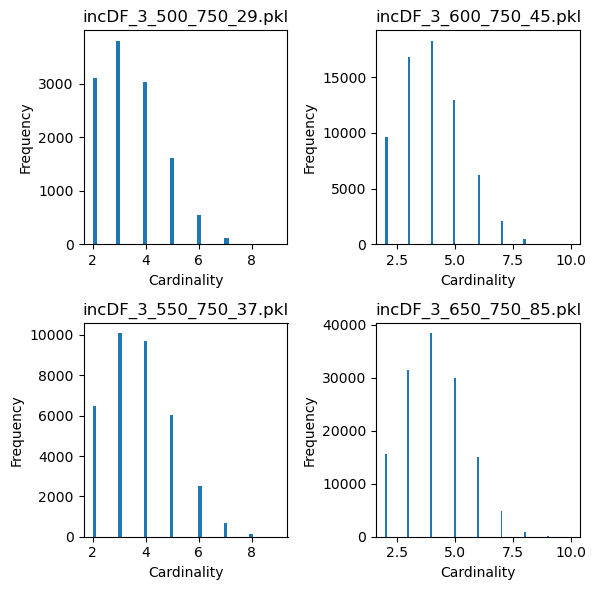

In [10]:
# Get the number of elements in the dictionary
num_plots = len(cardDict)

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = (num_plots + 1) // 2  # Ceiling division to ensure enough columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

# Flatten the axes array if necessary
axes = axes.flatten()

# Iterate through dictionary items and create histograms in subplots
for i, (filename, data) in enumerate(cardDict.items()):
    axes[i].hist(data,bins = "auto")
    axes[i].set_xlabel('Cardinality')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{filename}')
    
# Adjust layout
plt.tight_layout()

# Display the subplots
plt.show()

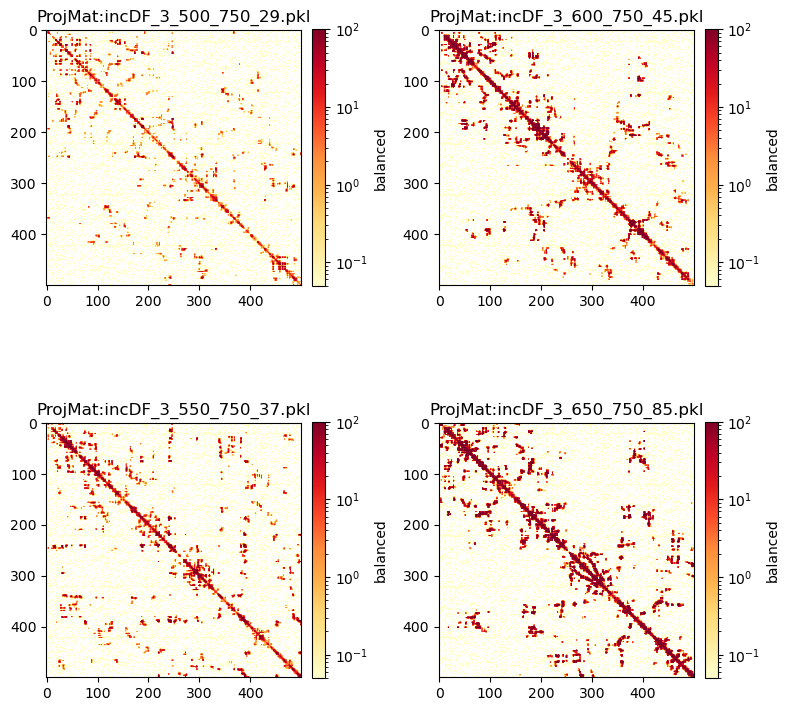

In [13]:
from matplotlib.colors import LogNorm

# Get the number of elements in the dictionary
num_plots = len(projMats)

# Calculate the number of rows and columns for subplots
num_rows = 2
num_cols = (num_plots + 1) // 2  # Ceiling division to ensure enough columns

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))

# Flatten the axes array if necessary
axes = axes.flatten()

# Iterate through dictionary items and create images in subplots
for i, (filename, data) in enumerate(projMats.items()):
    ax = axes[i]
    im = ax.imshow(data, cmap="YlOrRd", norm=LogNorm(vmax=100, vmin=0.05))
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='balanced')
    ax.set_title(f"ProjMat:{filename}")

# Adjust layout
plt.tight_layout()

# Display the subplots
plt.show()


## Edge pruning 

In [37]:
og = hpEdges.copy()

In [38]:
hpKeys = [k for k in hpEdges.keys()]
hpKeys_split = [k.split("_") for k in hpEdges.keys()]
keyCard = [len(item) for item in hpKeys_split]
totalReads = sum(hpEdges.values())
hpProbs = {k:(v/totalReads) for k,v in hpEdges.items()}

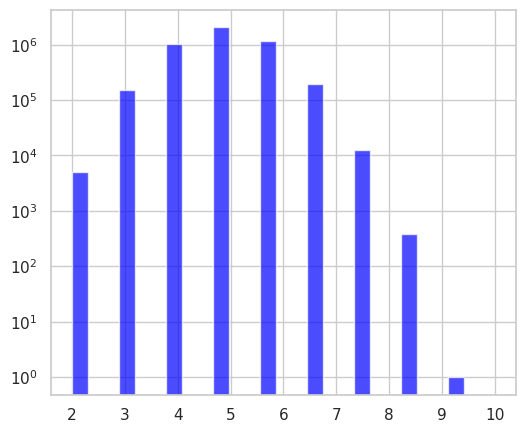

In [15]:
plt.figure(figsize=(6, 5))  # Set the figure size
plt.hist(keyCard, color='blue', alpha=0.7, width = 0.3, bins=9)
plt.yscale("log")
plt.show()

In [16]:
hpEdges = og.copy()

In [39]:
len(hpEdges)

6809863

In [46]:
hpEdges = og.copy()
flaggedEdges = []
for card in range(11,2,-1):
    print("Calculating for card=",card)
    ixList = [index for index,element in enumerate(keyCard) if element == card]
    print("There are ",len(ixList),"reads")
    for ix in ixList:
        hpEdges = prunePerHE(ix,hpKeys,hpKeys_split,hpEdges)

Calculating for card= 11
There are  0 reads
Calculating for card= 10
There are  8 reads
Calculating for card= 9
There are  521 reads
Calculating for card= 8
There are  15121 reads
Calculating for card= 7
There are  222813 reads
Calculating for card= 6
There are  1438671 reads
Calculating for card= 5
There are  3169943 reads
Calculating for card= 4
There are  1797009 reads
Calculating for card= 3
There are  160827 reads


In [45]:
# def prunePerHE(ix,hpKeys,hpKeys_split,hpEdges):
#     edge = hpKeys[ix]
#     if hpEdges[edge] > 0:
#       splitEdge = hpKeys_split[ix]
#       subsets = ['_'.join(map(str, a)) for a in combinations(splitEdge,len(splitEdge)-1)] 
#       if all(hpEdges[subset] and hpEdges[subset] >= hpEdges[edge] for subset in subsets):
#         for subset in subsets:
#           hpEdges[subset] -= hpEdges[edge]
#           return(hpEdges)
#       else:
#         flaggedEdges.append(edge)
#         return(hpEdges)
#     else:
#      return(hpEdges)

def prunePerHE(ix,hpKeys,hpKeys_split,hpEdges):
    edge = hpKeys[ix]
    #if hpEdges[edge] > 0:
    splitEdge = hpKeys_split[ix]
    subsets = ['_'.join(map(str, a)) for a in combinations(splitEdge,len(splitEdge)-1)] 
    for subset in subsets:
      hpEdges[subset] -= hpEdges[edge]
      return(hpEdges)
    # else:
    #  return(hpEdges)

In [ ]:
def deleteFalseEdges():
    edge = hpKeys[ix]

In [47]:
# hpKeys[100:104]
print(og['Bin5:9_Bin10:14_Bin30:34'])
print(hpEdges['Bin5:9_Bin10:14_Bin30:34'])

5115
1436


In [49]:
hpKeys2 = [k for k,v in hpEdges.items() if v > 0]
hpKeys_split2 = [k.split("_") for k,v in hpEdges.items() if v > 0]
keyCard2 = [len(item) for item in hpKeys_split2]


# plt.figure(figsize=(6, 5))  # Set the figure size
# plt.hist(keyCard2, color='blue', alpha=0.7, width = 0.3, bins=9)
# plt.hist(keyCard, color='maroon', alpha=0.7, width = 0.3, bins=9)
# plt.title("Cardinality distribution after pruning")
# plt.yscale("log")
# plt.show()


In [53]:
print(len(hpKeys))
print(len(hpKeys2))

hpKeys3 = [k for k,v in hpEdges.items()]
len(hpKeys3)

6809863
5427985


6809863

In [52]:
n, bins = np.histogram(keyCard, bins=9)
print(n)

n2, bins2 = np.histogram(keyCard2, bins=9)
print(n2)

print([n2[i]/n[i] for i in range(len(n))])

deletedPerc = [n2[i]/n[i] for i in range(len(n))]

[   4950  160827 1797009 3169943 1438671  222813   15121     521       8]
[   3746   78031 1180256 2628892 1310213  211649   14676     514       8]
[0.7567676767676768, 0.4851859451460265, 0.656789142402737, 0.829318382065545, 0.9107106489252929, 0.9498952036012261, 0.9705707294491105, 0.9865642994241842, 1.0]


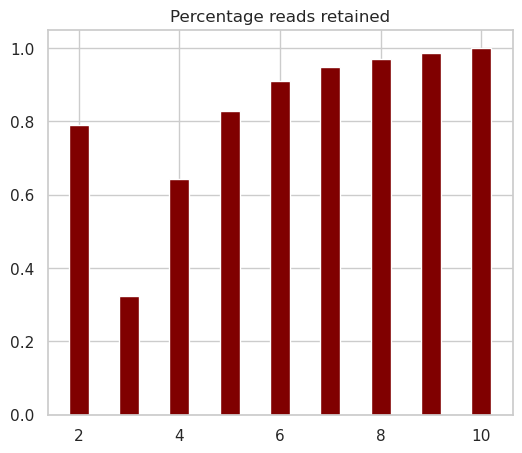

In [44]:
plt.figure(figsize=(6, 5))  # Set the figure size
plt.bar([i for i in range(2,11)],deletedPerc,color = "maroon",width = 0.4)
plt.title("Percentage reads retained")
plt.show()


In [191]:
hpKeys2[3813]

print(og['Bin125:129_Bin130:134_Bin155:159_Bin430:434'])
print(og['Bin125:129_Bin130:134'])
print(og['Bin130:134_Bin155:159'])

print(hpEdges['Bin125:129_Bin130:134_Bin155:159_Bin430:434'])
print(hpEdges['Bin125:129_Bin130:134'])
print(hpEdges['Bin130:134_Bin155:159'])

50
829312
85536
50
85910
15876


In [192]:
print(len(hpKeys))
print(len(hpKeys2))

#print(1692266/2632676)

2632676
2568214


In [194]:
print(len(flaggedEdges))
flaggedEdges[308437]

507404


'Bin50:54_Bin70:74_Bin105:109_Bin175:179_Bin245:249'

['Bin50:54', 'Bin70:74', 'Bin105:109', 'Bin175:179', 'Bin245:249']
                                                 Bins  NumReads         Probs  \
0                                   Bin50:54_Bin70:74     13687  2.354296e-05   
1                                 Bin50:54_Bin105:109     15889  3.858531e-05   
2                                 Bin50:54_Bin175:179     12760  3.630363e-05   
3                                 Bin50:54_Bin245:249      8832  2.684304e-05   
4                                 Bin70:74_Bin105:109     14935  3.147317e-05   
5                                 Bin70:74_Bin175:179     12989  3.213541e-05   
6                                 Bin70:74_Bin245:249     14837  4.281197e-05   
7                               Bin105:109_Bin175:179     16469  4.260884e-05   
8                               Bin105:109_Bin245:249     15691  4.325161e-05   
9                               Bin175:179_Bin245:249     17013  4.910604e-05   
10                       Bin50:54_Bin70:74

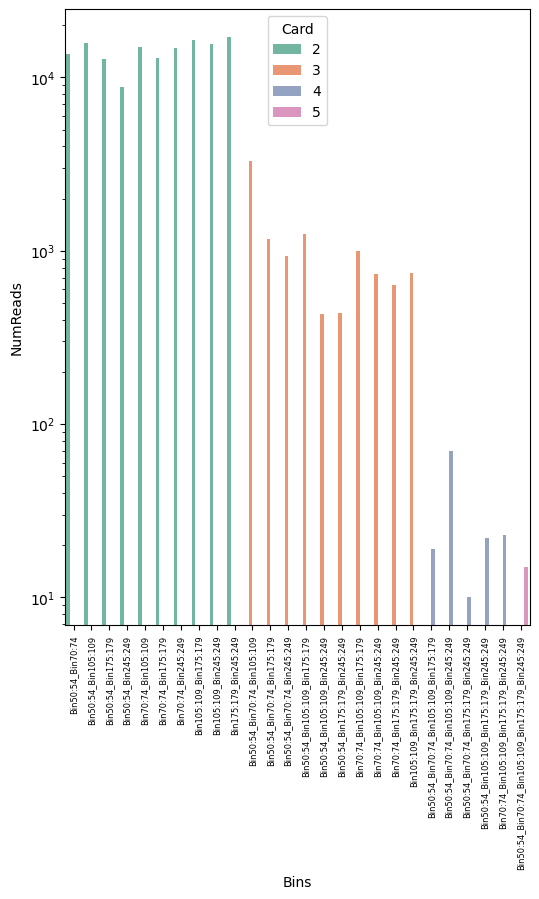

In [197]:
df1 = getSubsets(flaggedEdges[308437])

In [200]:
print(np.prod(df1['Probs'][:-1]))

print(df1['Probs'][-1:])

df1

6.255160741094167e-138
25    4.173791e-08
Name: Probs, dtype: float64


,Bins,NumReads,Probs,Card
0,Bin50:54_Bin70:74,13687,2.354296e-05,2
1,Bin50:54_Bin105:109,15889,3.858531e-05,2
2,Bin50:54_Bin175:179,12760,3.630363e-05,2
3,Bin50:54_Bin245:249,8832,2.684304e-05,2
4,Bin70:74_Bin105:109,14935,3.147317e-05,2
5,Bin70:74_Bin175:179,12989,3.213541e-05,2
6,Bin70:74_Bin245:249,14837,4.281197e-05,2
7,Bin105:109_Bin175:179,16469,4.260884e-05,2
8,Bin105:109_Bin245:249,15691,4.325161e-05,2
9,Bin175:179_Bin245:249,17013,4.910604e-05,2


In [196]:
def getSubsets(edge):
    ix = hpKeys2.index(edge)
    b = hpKeys_split2[ix]
    print(b)
    subsets = flatten([['_'.join(map(str, a)) for a in combinations(b,k)] for k in range(2,len(b)+1)])
    subsetCard = flatten([math.comb(len(b),k)*[k] for k in range(2,len(b)+1)])
    n = [x for x in subsets]
    l = [hpEdges[x] for x in subsets]
    subsetProbs = [hpProbs[x] for x in subsets]
    df = pd.DataFrame({'Bins': n, 'NumReads': l, 'Probs': subsetProbs, 'Card': subsetCard})
    print(df)
    plt.figure(figsize=(6, 8))  # Set the figure size
    sns.barplot(x='Bins', y='NumReads', hue='Card', data=df, palette='Set2')
    plt.yscale("log")
    plt.xticks(rotation=90,fontsize = 6)
    plt.show()
    return(df)

In [167]:
a = [index for index,element in enumerate(keyCard[0:30]) if element == 3]
b = [hpKeys_split[item] for item in a]
print(b)
print(len(b))

c = b[0]
print(c)

[['Bin0:4', 'Bin20:24', 'Bin25:29'], ['Bin0:4', 'Bin20:24', 'Bin95:99'], ['Bin0:4', 'Bin20:24', 'Bin115:119'], ['Bin0:4', 'Bin20:24', 'Bin385:389'], ['Bin0:4', 'Bin25:29', 'Bin30:34'], ['Bin0:4', 'Bin25:29', 'Bin95:99'], ['Bin0:4', 'Bin25:29', 'Bin115:119'], ['Bin0:4', 'Bin25:29', 'Bin385:389']]
8
['Bin0:4', 'Bin20:24', 'Bin25:29']


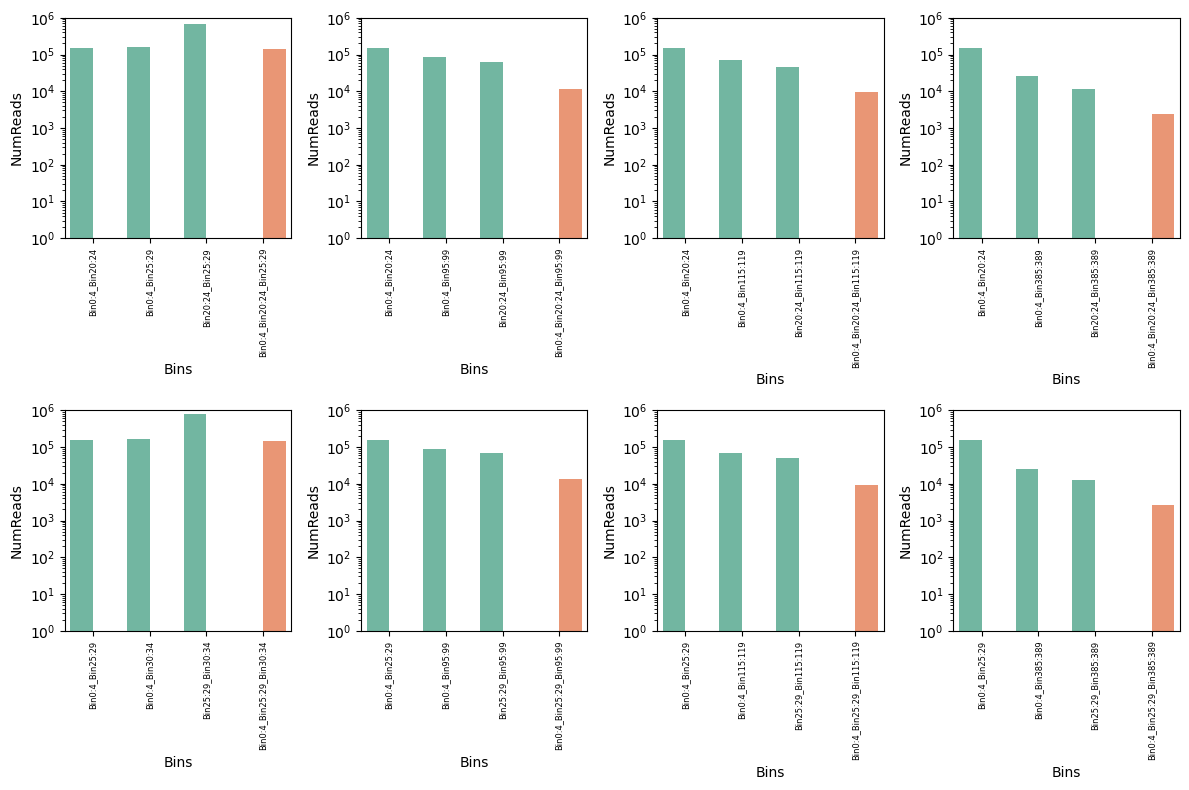

In [170]:
dfs = []
for item in b:
    edge = '_'.join(map(str,item))
    subsets = flatten([['_'.join(map(str, a)) for a in combinations(item,k)] for k in range(2,len(item)+1)])
    subsetCard = flatten([math.comb(len(item),k)*[k] for k in range(2,len(item)+1)])
    # print([s for s in subsets])
    # print([hpEdges[s] for s in subsets])

    n = [x for x in subsets]
    l = [hpEdges[x] for x in subsets]

    df = pd.DataFrame({'Bins': n, 'NumReads': l, 'Card': subsetCard})
    dfs.append(df)

# Determine the grid dimensions based on the number of DataFrames
num_rows = 2
num_cols = (len(dfs) + 1) // 2

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 4 * num_rows))
plt.subplots_adjust(hspace=0.5)
axes = axes.flatten()

for i, df in enumerate(dfs,1):
    ax = axes[i-1]
    sns.barplot(x='Bins', y='NumReads', hue='Card', data=df, palette='Set2',ax = ax)
    ax.set_yscale("log")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=6)
    ax.set_ylim(10**0, 10**6)
    ax.get_legend().remove()

plt.tight_layout()
plt.show()

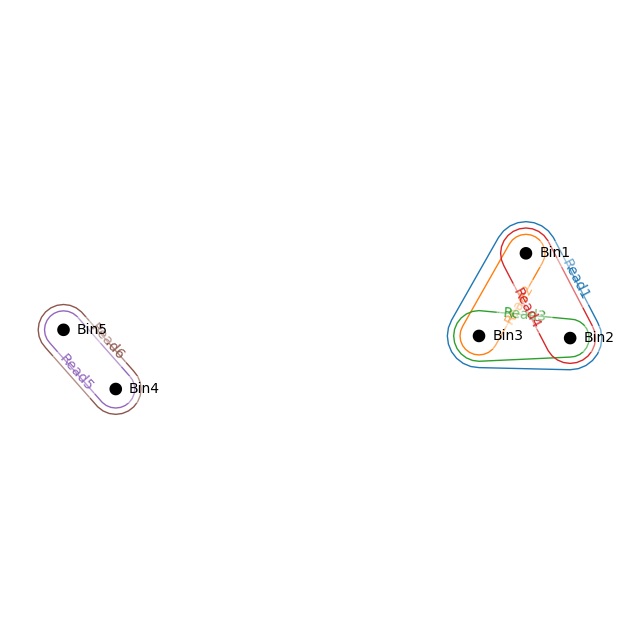

In [13]:
## Ideal case 
tmpDF = pd.DataFrame({
    'Read1':[1,1,1,0,0],'Read2':[1,0,1,0,0],'Read3':[0,1,1,0,0],'Read4':[1,1,0,0,0],
    'Read5':[0,0,0,1,1],'Read6':[0,0,0,1,1]},
    index=['Bin1','Bin2','Bin3','Bin4','Bin5'])

H = hnx.Hypergraph.from_incidence_dataframe(tmpDF)
hnx.draw(H)

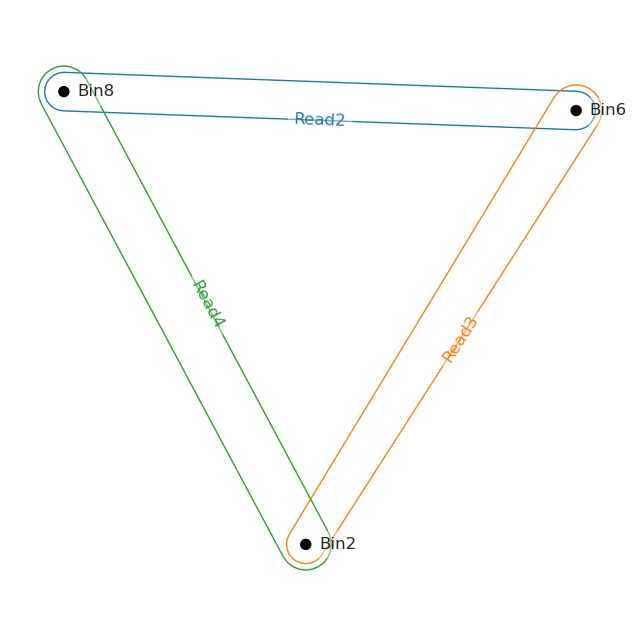

In [28]:
tmpDF2 = pd.DataFrame({'Read2':[0,1,1],'Read3':[1,1,0],'Read4':[1,0,1]},
    index=['Bin2','Bin6','Bin8'])

H2 = hnx.Hypergraph.from_incidence_dataframe(tmpDF2)
hnx.draw(H2)

In [138]:
[{i:n[l.index(i)]} for i in l if i <= 100]

[{51: 'Bin40:44_Bin45:49_Bin50:54_Bin80:84_Bin165:169'},
 {87: 'Bin40:44_Bin45:49_Bin50:54_Bin85:89_Bin165:169'},
 {77: 'Bin40:44_Bin45:49_Bin80:84_Bin85:89_Bin165:169'},
 {46: 'Bin40:44_Bin50:54_Bin80:84_Bin85:89_Bin165:169'},
 {39: 'Bin40:44_Bin45:49_Bin50:54_Bin80:84_Bin85:89_Bin165:169'}]

                       Bins  NumReads  Card
0           Bin0:4_Bin20:24    146248     2
1           Bin0:4_Bin25:29    156650     2
2         Bin20:24_Bin25:29    670503     2
3  Bin0:4_Bin20:24_Bin25:29    141764     3


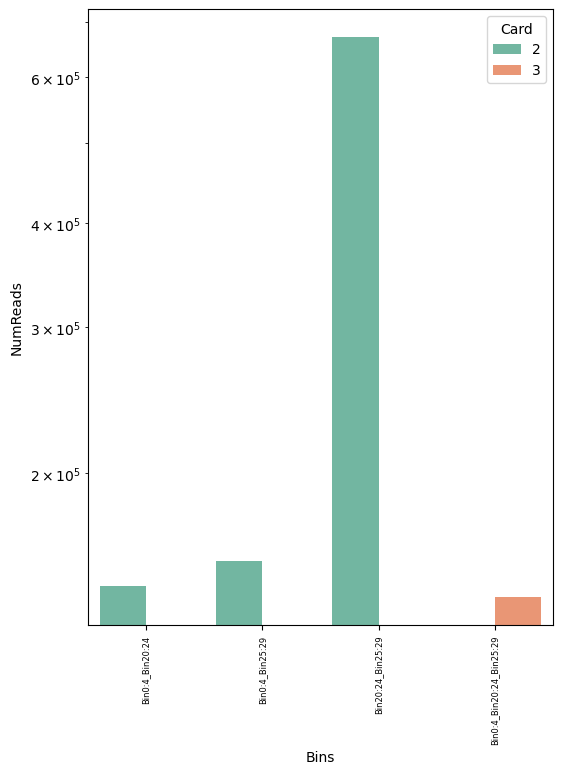

In [69]:
n = [x for x in subsets]
l = [hpEdges[x] for x in subsets]

df = pd.DataFrame({'Bins': n, 'NumReads': l, 'Card': subsetCard})
print(df)

plt.figure(figsize=(6, 8))  # Set the figure size
sns.barplot(x='Bins', y='NumReads', hue='Card', data=df, palette='Set2')
plt.yscale("log")
plt.xticks(rotation=90,fontsize = 6)
plt.show()

In [68]:
hpKeys = [k.split("_") for k in hpEdges.keys()]
keyCard = [len(item) for item in hpKeys]

In [73]:
keyCard.index(5)
hpKeys[68]

['Bin0:4', 'Bin20:24', 'Bin25:29', 'Bin95:99', 'Bin115:119']

In [133]:
pruned_edges = {key: value for key, value in hpEdges.items() if value >= 3}
rep_HD_edge = {key: value for key, value in hpEdges.items() if value >= 5 and len(key.split("_")) == 6}

In [171]:
rep_HD_edge
list(rep_HD_edge.keys())[0].split("_")

['Bin90:94',
 'Bin185:189',
 'Bin190:194',
 'Bin205:209',
 'Bin375:379',
 'Bin390:394']

In [163]:
{key:value for key, value in pruned_edges.items() if key in rep_HD_edge}

{'Bin90:94_Bin185:189_Bin190:194_Bin205:209_Bin375:379_Bin390:394': 5}

In [172]:
A = [k for k in hpEdges.keys()]
A[0:4]

['Bin0:4_Bin30:34',
 'Bin0:4_Bin115:119',
 'Bin0:4_Bin385:389',
 'Bin0:4_Bin390:394']

In [166]:
hpEdges['Bin90:94_Bin375:379']

24

## Re-doing 2024-04

In [4]:
import numpy as np
import argparse
import pickle
import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')

import importlib
from v1_chains import IncDFCreator

In [3]:
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'
inputDir = 'chains_500_10000_1500_1681171613/'
file_num = 563
# outDir = f'{dataDir}{args.outDir}/'

## Read in distance file
exMat = np.loadtxt(f'{dataDir}{inputDir}/chain_dist_{file_num}.txt')

In [8]:
creator = IncDFCreator(4, 500, 550, 3)
oneIter = creator.makeIncDF_fromChainDists_mp(exMat)
exChain = oneIter[0]
ratios = oneIter[1]

In [11]:
from scipy.spatial import cKDTree
exCoords = np.loadtxt(f'{dataDir}{inputDir}/chain_{file_num}.txt')

In [12]:
tree = cKDTree(exCoords)

In [28]:
hits = tree.query_ball_point(exCoords,450)
hits_highorder = [x for x in hits if len(x) > 2]

In [29]:
len(hits_highorder)

500

In [30]:
hits_highorder[0]

[0, 1, 2, 21, 25, 26, 29, 30, 97]

#### Okay this just gets the nearest neighbor, which is not the bottleneck. Time inefficiency comes from trying to get all n choose k subsets and testing for neighbors in that